In [506]:
import numpy as np
import torch
from sklearn.decomposition import PCA
from abc import ABCMeta, abstractmethod

from datasets import SynthDataset
from synth_utils import js_div, kl_div, pca
from priors import FactorizedNormalPrior
from bgan import BGAN

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [571]:
data = SynthDataset(x_dim=2, true_z_dim=2, N=500, num_clusters=3, seed=1234)
dataloader = torch.utils.data.DataLoader(data, batch_size=50, shuffle=True)

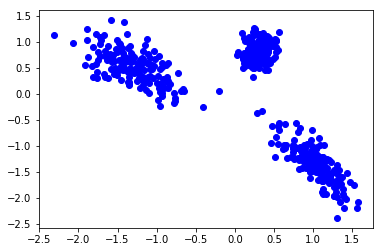

In [572]:
x = data.X.numpy()
# x_r, x_f = pca(x, x)
plt.plot(x[:, 0], x[:, 1], 'bo')

## BGAN

In [607]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [723]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.05)
        m.bias.data.normal_(0.0, 0.02)

def weights_init_disc(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)

    
class GeneratorNetwork(nn.Module):
    
    def __init__(self, z_dim, x_dim, h_dim):
        super(GeneratorNetwork, self).__init__()
        self.build_net(z_dim, x_dim, h_dim)
        self.input_dim = z_dim
        self.output_dim = x_dim
    
    def build_net(self, z_dim, x_dim, h_dim):
        self.network = nn.Sequential(
            nn.Linear(z_dim, h_dim),#, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(h_dim, x_dim)#, bias=False)
        )
    
    def forward(self, input):
        # TODO: understand parallelism?
        output = self.network(input)
        return output

class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, x_dim, K, h_dim):
        super(DiscriminatorNetwork, self).__init__()
        self.build_net(x_dim, K, h_dim)
        self.K = K
    
    def build_net(self, x_dim, K, h_dim):
        self.network = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(h_dim, K),
            nn.Softmax()
        )
    
    def forward(self, input):
        # TODO: understand parallelism?
        output = self.network(input)
        return output

In [724]:
batch_size = 64
z_dim = 2
z = torch.rand(batch_size, z_dim)
z_var = Variable(z)
num_samples = 100

In [725]:
prior = FactorizedNormalPrior(std=10.)
gen = GeneratorNetwork(z_dim, 2, 100)
disc = DiscriminatorNetwork(2, 2, 100)
gen.apply(weights_init)
disc.apply(weights_init_disc)
bgan = BGAN(gen, disc, prior, alpha=.01, eta=5e-5, num_data=len(data), disc_lr=5e-5, gen_observed=500)
samples = []

In [726]:
for param in gen.parameters():
    print(param.size(), np.linalg.norm(param.data.numpy()))

torch.Size([100, 2]) 0.688103
torch.Size([100]) 0.19534
torch.Size([2, 100]) 0.63824
torch.Size([2]) 0.0367404


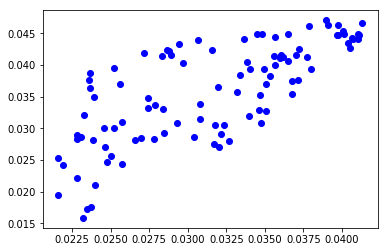

In [727]:
samples = bgan.sample(100).data.numpy()
plt.plot(samples[:, 0], samples[:, 1], 'bo')

In [728]:
def visualize(samples, x_min=None, x_max=None, y_min=None, y_max=None, with_samples=True, n_grid=500):
    min_samples = np.array((np.min(samples[:, 0]), np.min(samples[:, 1])))
    max_samples = np.array((np.max(samples[:, 0]), np.max(samples[:, 1])))
    min_x = np.array((np.min(x[:, 0]), np.min(x[:, 1])))
    max_x = np.array((np.max(x[:, 0]), np.max(x[:, 1])))
    min_ = np.min(np.vstack([min_samples[None, :], min_x[None, :]]), axis=0)
    max_ = np.max(np.vstack([max_samples[None, :], max_x[None, :]]), axis=0)
#     print(min_, max_)
#     print(np.hstack([max_samples[None, :], max_x[None, :]]))
    if x_max is None: x_max = max_[0]
    if x_min is None: x_min = min_[0]
    if y_max is None: y_max = max_[1]
    if y_min is None: y_min = min_[1]
    
    w_grid_x = np.linspace(x_min, x_max, num=n_grid)
    w_grid_y = np.linspace(y_min, y_max, num=n_grid)
    w_grid_x_, w_grid_y_ = np.meshgrid(w_grid_x, w_grid_y)
    w_grid_x_ = w_grid_x_.reshape(-1)[:, None]
    w_grid_y_ = w_grid_y_.reshape(-1)[:, None]
    w_grid = np.hstack([w_grid_x_, w_grid_y_])
    
    probs = disc.forward(Variable(torch.from_numpy(w_grid).float())).data.numpy()
    probs = (probs[:, 0]).reshape(n_grid, n_grid)
    plt.figure(figsize=(15, 10))
    CS = plt.contour(w_grid_x, w_grid_y, probs)
# #     print(w_grid_x)
    plt.clabel(CS, inline=1, fontsize=10)
#     plt.title('Simplest default with labels')
    plt.plot(x[:, 0], x[:, 1], 'bo', alpha=0.1)
    if with_samples:
        plt.plot(samples[:, 0], samples[:, 1], 'go')
        plt.plot(samples[-1, 0], samples[-1, 1], 'go', markersize=10)
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    
    im = plt.imshow(probs, interpolation='bilinear', origin='lower',
            cmap='hot', extent=(x_min, x_max, y_min, y_max))
    plt.colorbar()

In [729]:
if isinstance(samples, np.ndarray):
    samples = samples.tolist()
    
for epoch in range(500):
    for i, data_ in enumerate(dataloader, 0):
        batch = data_.float()
        bgan.step(batch)
    if not epoch%1:
        batchv = Variable(batch)
        d_loss, g_loss = bgan.loss(batchv)
        print('\t', d_loss.data.numpy()[0], g_loss.data.numpy()[0])
    if not epoch%10:
        print(epoch)
    if not epoch%10:
        samples.append(bgan.sample(num_samples).data.numpy())
samples = np.vstack(samples)

	 1.38262 0.657688
0
	 1.3819 0.716415
	 1.38161 0.716563
	 1.38117 0.714572
	 1.37895 0.688692
	 1.37923 0.684689
	 1.37744 0.689414
	 1.3788 0.754185
	 1.37757 0.732188
	 1.37608 0.715134
	 1.37466 0.629368
10
	 1.37321 0.694836
	 1.37399 0.704936
	 1.37361 0.6955
	 1.37071 0.656407
	 1.37037 0.686138
	 1.36775 0.793319
	 1.36921 0.736786
	 1.36606 0.700657
	 1.36689 0.664501
	 1.36474 0.637305
20
	 1.36069 0.69254
	 1.35899 0.746388
	 1.36335 0.701343
	 1.36043 0.713219
	 1.35909 0.633938
	 1.35431 0.71072
	 1.3558 0.758489
	 1.35152 0.708756
	 1.35093 0.722797
	 1.34744 0.683368
30
	 1.34202 0.729317
	 1.34913 0.627702
	 1.34529 0.683455
	 1.34032 0.733755
	 1.34425 0.73552
	 1.33429 0.755668
	 1.33628 0.700806
	 1.33385 0.702647
	 1.33113 0.690733
	 1.32916 0.763506
40
	 1.32696 0.7354
	 1.32567 0.655349
	 1.32357 0.682901
	 1.32019 0.696781
	 1.3197 0.656209
	 1.32129 0.714634
	 1.3202 0.788971
	 1.30449 0.716899
	 1.30085 0.766326
	 1.30743 0.732545
50
	 1.2996 0.734991
	 1.2904

	 0.687375 1.68871
	 0.744781 1.49904
	 0.65134 1.60243
	 0.576839 1.4179
	 0.617039 1.41954
	 0.655866 1.59785
430
	 0.659665 1.49674
	 0.606064 1.60792
	 0.680642 1.67733
	 0.702751 1.65476
	 0.707124 1.57196
	 0.655089 1.72357
	 0.761452 1.57884
	 0.748187 1.63675
	 0.656824 1.51066
	 0.640492 1.48997
440
	 0.576788 1.52949
	 0.753625 1.45962
	 0.752054 1.5499
	 0.564335 1.61684
	 0.664896 1.51633
	 0.611255 1.72053
	 0.738946 1.64972
	 0.526976 1.56496
	 0.66013 1.71192
	 0.721574 1.59319
450
	 0.594148 1.61876
	 0.659783 1.668
	 0.615819 1.61689
	 0.658395 1.76127
	 0.679482 1.76285
	 0.754058 1.66718
	 0.729449 1.75009
	 0.743769 1.5113
	 0.684671 1.54942
	 0.602874 1.54965
460
	 0.658774 1.61365
	 0.60943 1.55503
	 0.697089 1.53584
	 0.526592 1.62429
	 0.557278 1.58594
	 0.731104 1.7368
	 0.683643 1.72672
	 0.770436 1.52333
	 0.632969 1.60723
	 0.592091 1.5651
470
	 0.62 1.56746
	 0.603797 1.58191
	 0.545908 1.60915
	 0.653153 1.55871
	 0.513264 1.6019
	 0.65887 1.46691
	 0.5798

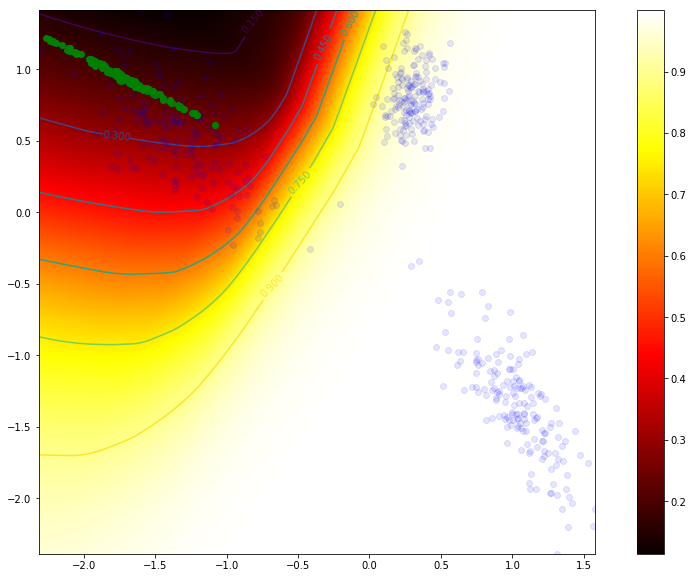

In [730]:
vis_samples = bgan.sample(100).data.numpy()
visualize(vis_samples)

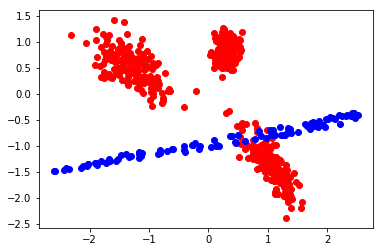

In [707]:
plt.plot(x[:, 0], x[:, 1], 'ro')
plt.plot(samples[-num_samples:][:, 0], samples[-num_samples:][:, 1], 'bo')

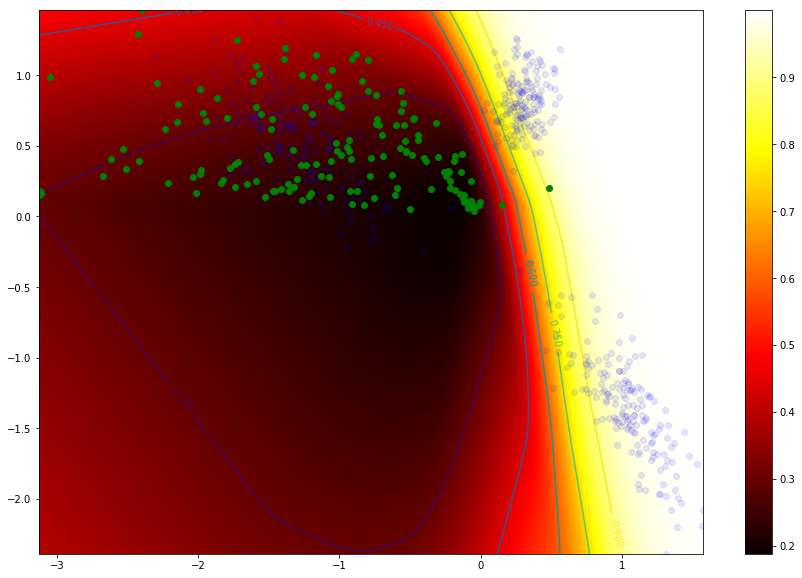

In [702]:
epoch_samples = []
for j in range(int(samples.shape[0] / num_samples)):
    epoch_samples.append(samples[j*num_samples][None, :])
epoch_samples = np.vstack(epoch_samples)
visualize(epoch_samples)

In [675]:
bgan.generator.zero_grad()
d_loss, g_loss = bgan.loss(batchv)
d_loss /= bgan.eta
g_loss /= bgan.eta

In [676]:
d_loss

Variable containing:
 18284.9668
[torch.FloatTensor of size 1]

In [537]:
g_loss

Variable containing:
 23466.5000
[torch.FloatTensor of size 1]

In [538]:
g_loss.backward()

In [539]:
for param in gen.parameters():
    print(param.grad.size(), np.linalg.norm(param.data.numpy()), np.linalg.norm(param.grad.data.numpy()))

torch.Size([100, 2]) 0.429332 16134.9
torch.Size([100]) 0.413829 19801.9
torch.Size([2, 100]) 0.699892 32933.8
torch.Size([2]) 0.101361 50175.8


trajectory

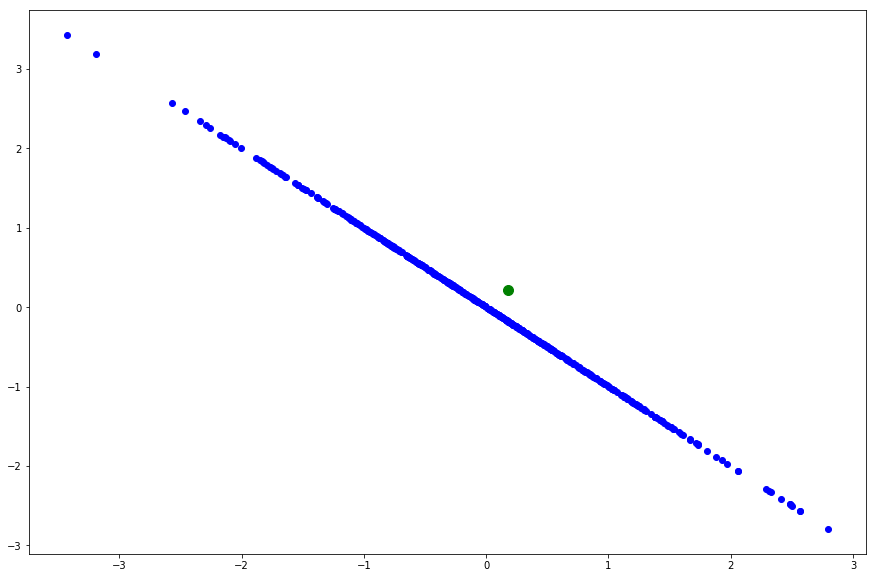

In [1410]:
plt.figure(figsize=(15, 10))
epoch_samples = []
for j in range(int(samples.shape[0] / num_samples)):
    epoch_samples.append(samples[j*num_samples][None, :])
epoch_samples = np.vstack(epoch_samples)
plt.plot(x[:, 0], x[:, 1], 'bo')
plt.plot(epoch_samples[:, 0], epoch_samples[:, 1], '-r')
plt.plot(epoch_samples[-1, 0], epoch_samples[-1, 1], 'go', markersize=10)


Samples for a specific epoch

In [1411]:
int(samples.shape[0] / num_samples)

1

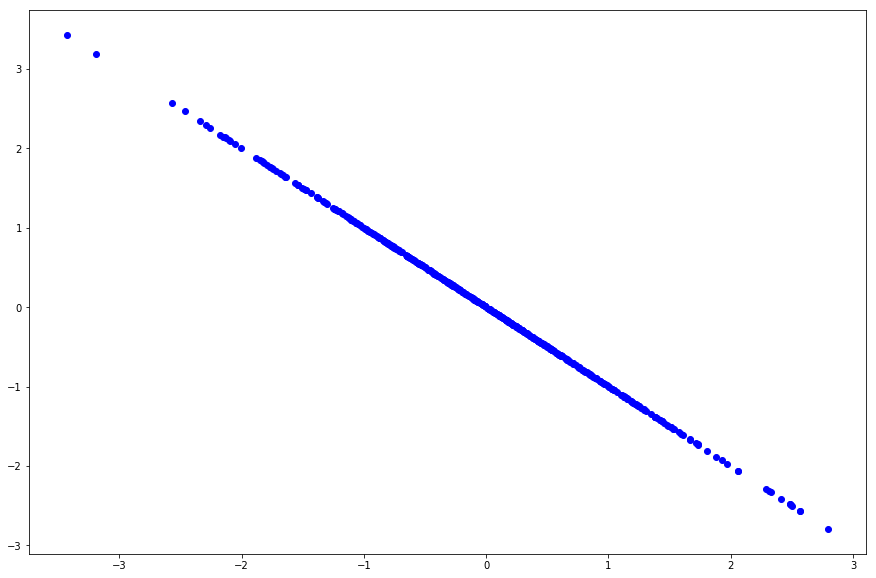

In [1412]:
plt.figure(figsize=(15, 10))
j=9
plt.plot(x[:, 0], x[:, 1], 'bo')
plt.plot(samples[j*num_samples:(j+1) * num_samples, 0], samples[j*num_samples:(j+1) * num_samples, 1], 'ro')

In [1413]:
for param in gen.parameters():
    print(param)

Parameter containing:
 0.7409
-0.7955
[torch.FloatTensor of size 2x1]

Parameter containing:
-0.1962
 0.6185
[torch.FloatTensor of size 2]



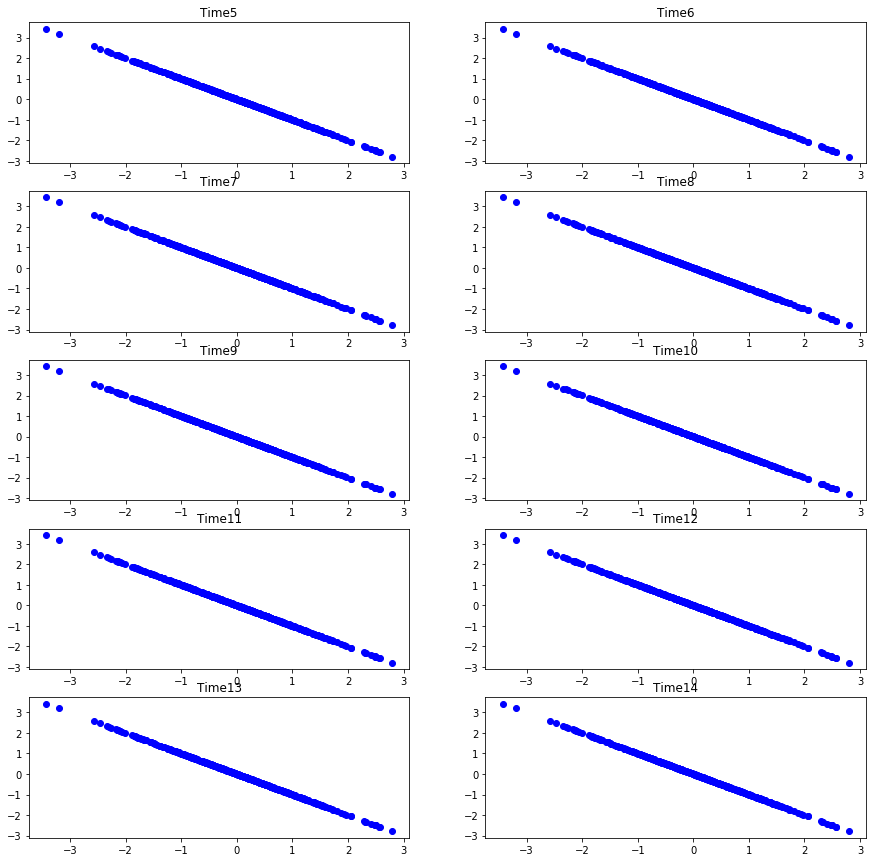

In [1414]:
ax, arr = plt.subplots(5, 2, figsize=(15,15))
start = 5
for i in range(10):
    j = start + i
    arr[int(i / 2), i%2].set_title('Time'+str(j) )
    arr[int(i / 2), i%2].plot(x[:, 0], x[:, 1], 'bo')
    arr[int(i / 2), i%2].plot(samples[j*num_samples:(j+1) * num_samples, 0], samples[j*num_samples:(j+1) * num_samples, 1], 'ro')

In [331]:
batchv = Variable(batch.float())

In [334]:
disc(Variable(batch))

Variable containing:
 9.9893e-01  1.0713e-03
 9.8855e-01  1.1449e-02
 9.9998e-01  1.8826e-05
 1.0000e+00  1.3981e-20
 9.9897e-01  1.0328e-03
 9.9934e-01  6.5807e-04
 9.9258e-01  7.4212e-03
 9.9796e-01  2.0390e-03
 9.9516e-01  4.8416e-03
 9.9993e-01  7.3978e-05
 1.0000e+00  3.4747e-24
 9.8847e-01  1.1535e-02
 1.0000e+00  1.2048e-15
 9.9995e-01  4.8490e-05
 1.0000e+00  1.6041e-21
 9.9862e-01  1.3772e-03
 1.0000e+00  8.1837e-24
 1.0000e+00  1.4217e-21
 1.0000e+00  5.0362e-25
 1.0000e+00  2.7829e-06
 9.9993e-01  6.9827e-05
 1.0000e+00  6.5215e-25
 1.0000e+00  1.3009e-18
 1.0000e+00  1.5159e-25
 1.0000e+00  1.6318e-07
 9.9857e-01  1.4323e-03
 1.0000e+00  1.5382e-22
 1.0000e+00  5.9883e-24
 9.8516e-01  1.4838e-02
 9.8478e-01  1.5216e-02
 1.0000e+00  1.4476e-06
 9.9855e-01  1.4545e-03
 1.0000e+00  1.9629e-07
 9.9987e-01  1.2547e-04
 9.4230e-01  5.7699e-02
 1.0000e+00  2.1870e-25
 1.0000e+00  2.9642e-22
 1.0000e+00  7.7017e-07
 9.9905e-01  9.4695e-04
 9.8478e-01  1.5224e-02
 9.5375e-01  4.6255

In [336]:
disc(bgan.sample(100))

Variable containing:
 2.9755e-01  7.0245e-01
 6.7328e-06  9.9999e-01
 6.5691e-04  9.9934e-01
 9.4363e-07  1.0000e+00
 3.4531e-02  9.6547e-01
 4.4559e-01  5.5441e-01
 2.9694e-05  9.9997e-01
 2.7511e-01  7.2489e-01
 8.8437e-03  9.9116e-01
 9.9911e-07  1.0000e+00
 1.8099e-02  9.8190e-01
 6.2763e-03  9.9372e-01
 2.8519e-02  9.7148e-01
 6.3311e-02  9.3669e-01
 2.2369e-05  9.9998e-01
 1.3606e-04  9.9986e-01
 2.0027e-06  1.0000e+00
 2.7166e-06  1.0000e+00
 1.5493e-06  1.0000e+00
 4.6811e-07  1.0000e+00
 2.9048e-01  7.0952e-01
 3.1902e-02  9.6810e-01
 8.8946e-03  9.9111e-01
 1.7034e-06  1.0000e+00
 2.1927e-01  7.8073e-01
 1.8518e-05  9.9998e-01
 1.6868e-06  1.0000e+00
 1.0811e-06  1.0000e+00
 1.8380e-06  1.0000e+00
 1.8133e-05  9.9998e-01
 2.0630e-02  9.7937e-01
 8.9374e-03  9.9106e-01
 3.9764e-04  9.9960e-01
 2.9878e-05  9.9997e-01
 5.1483e-07  1.0000e+00
 4.7236e-06  1.0000e+00
 1.1880e-02  9.8812e-01
 1.0339e-03  9.9897e-01
 7.3821e-06  9.9999e-01
 1.0684e-01  8.9316e-01
 8.0351e-07  1.0000

## 10-D problem

In [337]:
x_dim = 10
data = SynthDataset(x_dim=x_dim, N=5000, num_clusters=3, seed=0)
dataloader = torch.utils.data.DataLoader(data, batch_size=50, shuffle=True)

In [338]:
batch_size = 50
z_dim = 2
z = torch.rand(batch_size, z_dim)
z_var = Variable(z)

In [341]:
prior = FactorizedNormalPrior(std=10.)
gen = GeneratorNetwork(x_dim, 1, 200)
disc = DiscriminatorNetwork(x_dim, 2, 200)
gen.apply(weights_init)
disc.apply(weights_init)
bgan = BGAN(gen, disc, prior, prior, alpha=.1, eta=1e-6, num_data=len(data), disc_lr=1e-4)
samples = []